In [1]:
%run ../../_setup.py

import numpy as np
from netCDF4 import Dataset
from gsw import sigma0
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
savefig = True

In [3]:
# load ctd and gsw data
input_file = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')
ctd.variables.keys()

odict_keys(['station', 'time', 'lon', 'lat', 'bot_lon', 'bot_lat', 'depth', 'p', 't', 'SP', 'O2', 'ts_t', 'ts_SP', 'ts_O2', 'SA', 'CT', 'g', 'z', 'pt', 'sigma0', 'spiciness0', 'deltaD', 'lonv', 'latv', 'Vg', 'gamman'])

In [4]:
transects = {1: list(range(3, 11)), 2: list(reversed(range(11, 19))), 3: list(range(19, 28)),
         4: list(reversed(range(27, 35))), 5: list(range(37, 47)), 6: list(reversed(range(47, 58))),
         7: list(range(57, 66)), 8: list(range(69, 77)), 9: list(reversed(range(77, 85))),
         10: list(range(85, 92)), 11: list(reversed([94, 93] + list(range(95, 102))))}


# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
# p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

# neutral density contours for T-S diagram
trues = np.isfinite(D)
trues[0], trues[1] = False, False

CTi = np.linspace(np.nanmin(ctd['CT']), np.nanmax(ctd['CT']))
SAi = np.linspace(np.nanmin(ctd['SA']), np.nanmax(ctd['SA']))
SAgrd, ptgrd = np.meshgrid(SAi, CTi)
gamman = np.ma.masked_invalid(ctd['gamman'][:])
mask = gamman[trues].mask


points = list(zip(ctd['SA'][trues][~mask].flatten(), ctd['CT'][trues][~mask].flatten()))
values = gamman[trues][~mask].flatten()
# points.shape, values.shape
gammangrd = griddata(points, values, (SAgrd, ptgrd), method='linear')

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Warning: converting a masked element to nan.


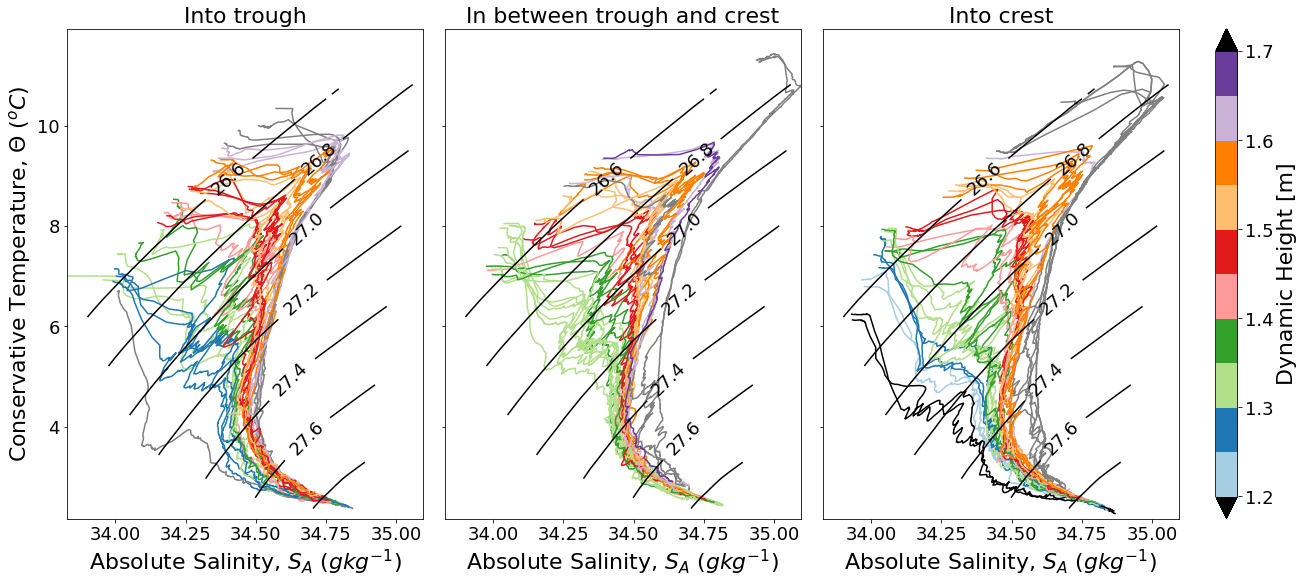

In [8]:
fs_small=18
fs_large=22

plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)

nts = len(transects.keys())
odds = [1, 2, 9, 10, 11, 12, 27, 45, 46, 47, 75, 76, 77, 78, 101]

areas = {'Into trough': range(8, 12), 'In between trough and crest': range(5, 8), 'Into crest': range(1, 5)}

titles = {'CT': r'Conservative Temperature, $\Theta$ ($^o C$)', r'SA': 'Absolute Salinity, $S_A$ ($gkg^{-1}$)'}

ncolors = 10
bounds = np.linspace(1.2, 1.7, ncolors+1)
norm = mcolors.BoundaryNorm(bounds, ncolors=ncolors)

colors = plt.cm.Paired(np.linspace(0, 1, 12))
cmap = mcolors.ListedColormap(colors[:-2], "")
cmap.set_under('k')
cmap.set_over('k')

fig, axes = plt.subplots(1, 3, figsize=(18, 8), constrained_layout=True, sharey=True)

for ax, area in zip(axes.flat, areas.keys()):
#     ct = ax.contour(SAgrd, ptgrd, sig0grd, colors='k')
#     ax.clabel(ct, inline=1, fontsize=8, fmt='%.1f')
    ct = ax.contour(SAi, CTi, gammangrd, colors='k', zorder=1000)
    ax.clabel(ct, inline=1, fontsize=fs_small, fmt='%.1f')
    for transect in areas[area]:
        
        for station in transects[transect]:
            ist = station - 1
            if station not in odds:
                ax.plot(ctd['SA'][ist], ctd['pt'][ist], color=cmap(norm(D[ist])))
            else:
                ax.plot(ctd['SA'][ist], ctd['pt'][ist], color='grey')
    ax.set_title(area, fontsize=fs_large)
    if area == 'Into trough':
        ax.set_ylabel(titles['CT'], fontsize=fs_large)
    ax.set_xlabel(titles['SA'], fontsize=fs_large)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(bounds)
cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), aspect=50, orientation='vertical',extend='both')
cbar.set_label('Dynamic Height [m]', fontsize=fs_large)

if savefig:
    fignumber = '08_'
    figname = 't-s-variability'
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname + extension), transparent=True)

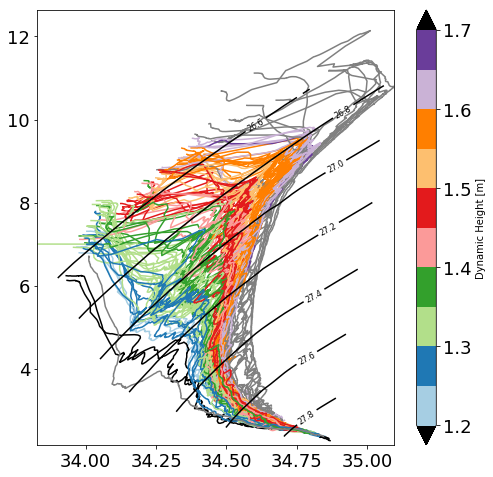

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
ct = ax.contour(SAi, CTi, gammangrd, colors='k', zorder=1000)
ax.clabel(ct, inline=1, fontsize=8, fmt='%.1f')

for ist, station in enumerate(ctd['station'][:]):

    if station not in odds:
        ax.plot(ctd['SA'][ist], ctd['pt'][ist], color=cmap(norm(D[ist])))
    else:
        ax.plot(ctd['SA'][ist], ctd['pt'][ist], color='grey')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(bounds)
cbar = plt.colorbar(sm, orientation='vertical',extend='both')
cbar.set_label('Dynamic Height [m]')


In [8]:
ip = pressure_levels[200]
theta400db = np.array([ctd['pt'][station, ip] for station in range(ctd['pt'].shape[0])])
np.where(theta400db <= 2.12)

(array([], dtype=int64),)

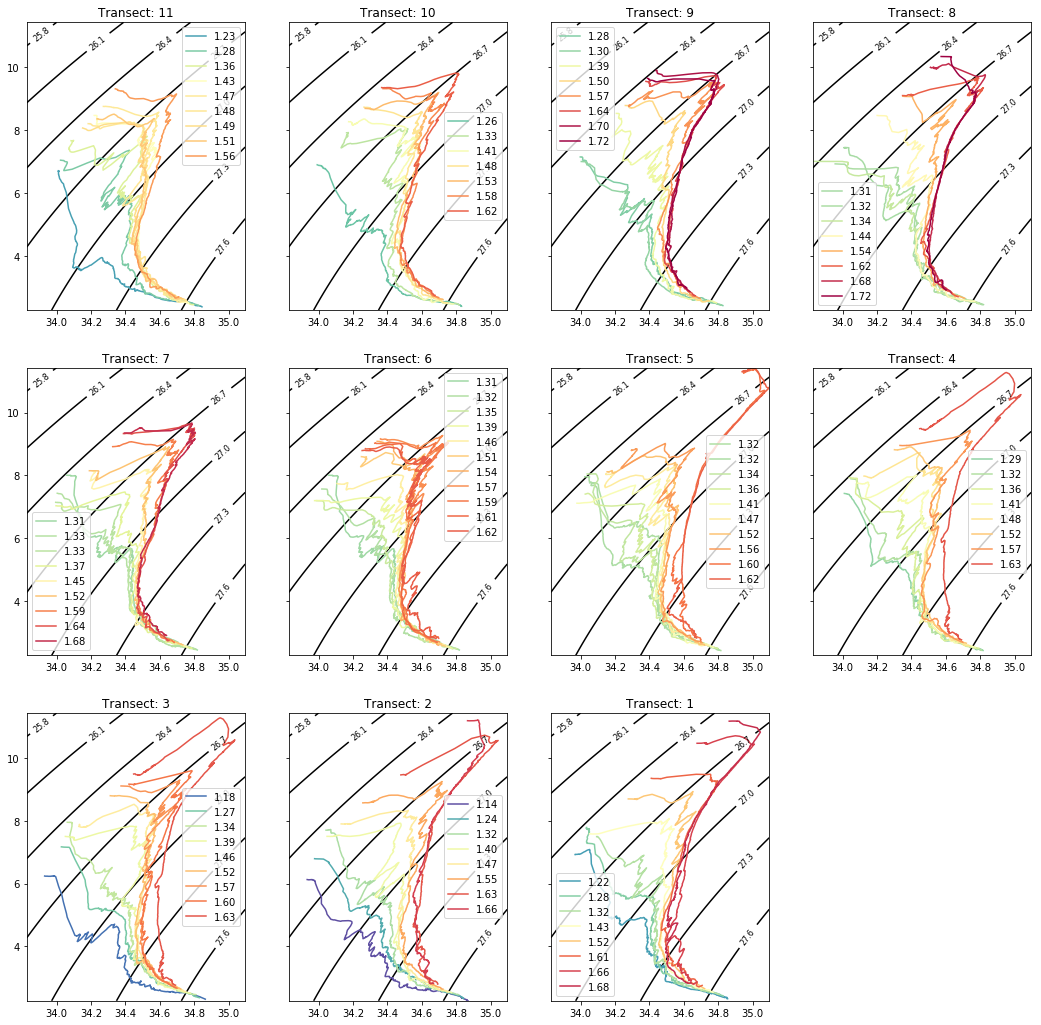

In [9]:
# cmap = plt.cm.get_cmap('Spectral_r')
# rgba = cmap(0.5)

def norm(val, values):
    return (val - np.nanmin(values)) / float(np.nanmax(values) - np.nanmin(values))

fig, ax = plt.subplots(3, 4, figsize=(18, 18), sharey=True)
for transect in reversed(list(transects.keys())):
    row, col = abs(transect - 11) // 4, abs(transect - 11) % 4

    
    ct = ax[row, col].contour(SAgrd, ptgrd, sig0grd, colors='k')
    ax[row, col].clabel(ct, inline=1, fontsize=8, fmt='%.1f')
    
    
    for ist, station in enumerate(transects[transect]):
#         norm = (D[station-1] - np.nanmin(D)) / (np.nanmax(D) - np.nanmin(D))
        color = plt.cm.Spectral_r(norm(D[station-1], D))
        ax[row, col].plot(ctd['SA'][station-1], ctd['pt'][station-1], 
                          label='{0:.2f}'.format(D[station-1]), color=color)
    ax[row, col].legend()
    ax[row, col].set_title('Transect: %s' % transect)
fig.delaxes(ax[2][3])

In [8]:
np.arctan(300/5000)*(180/np.pi)

3.433630362450522